**MNIST Databse Classification Using LSTM**

*Importing and treating the Dataset*

In [24]:
import numpy as np
import struct
from array import array
from os.path  import join

#
# MNIST Data Loader Class
#
class MnistDataloader(object):
    def __init__(self, training_images_filepath,training_labels_filepath,
                 test_images_filepath, test_labels_filepath):
        self.training_images_filepath = training_images_filepath
        self.training_labels_filepath = training_labels_filepath
        self.test_images_filepath = test_images_filepath
        self.test_labels_filepath = test_labels_filepath

    def read_images_labels(self, images_filepath, labels_filepath):
        labels = []
        with open(labels_filepath, 'rb') as file:
            magic, size = struct.unpack(">II", file.read(8))
            if magic != 2049:
                raise ValueError('Magic number mismatch, expected 2049, got {}'.format(magic))
            labels = array("B", file.read())

        with open(images_filepath, 'rb') as file:
            magic, size, rows, cols = struct.unpack(">IIII", file.read(16))
            if magic != 2051:
                raise ValueError('Magic number mismatch, expected 2051, got {}'.format(magic))
            image_data = array("B", file.read())
        images = []
        for i in range(size):
            images.append([0] * rows * cols)
        for i in range(size):
            img = np.array(image_data[i * rows * cols:(i + 1) * rows * cols])
            img = img.reshape(28, 28)
            images[i][:] = img

        return images, labels

    def load_data(self):
        x_train, y_train = self.read_images_labels(self.training_images_filepath, self.training_labels_filepath)
        x_test, y_test = self.read_images_labels(self.test_images_filepath, self.test_labels_filepath)
        return (x_train, y_train),(x_test, y_test)

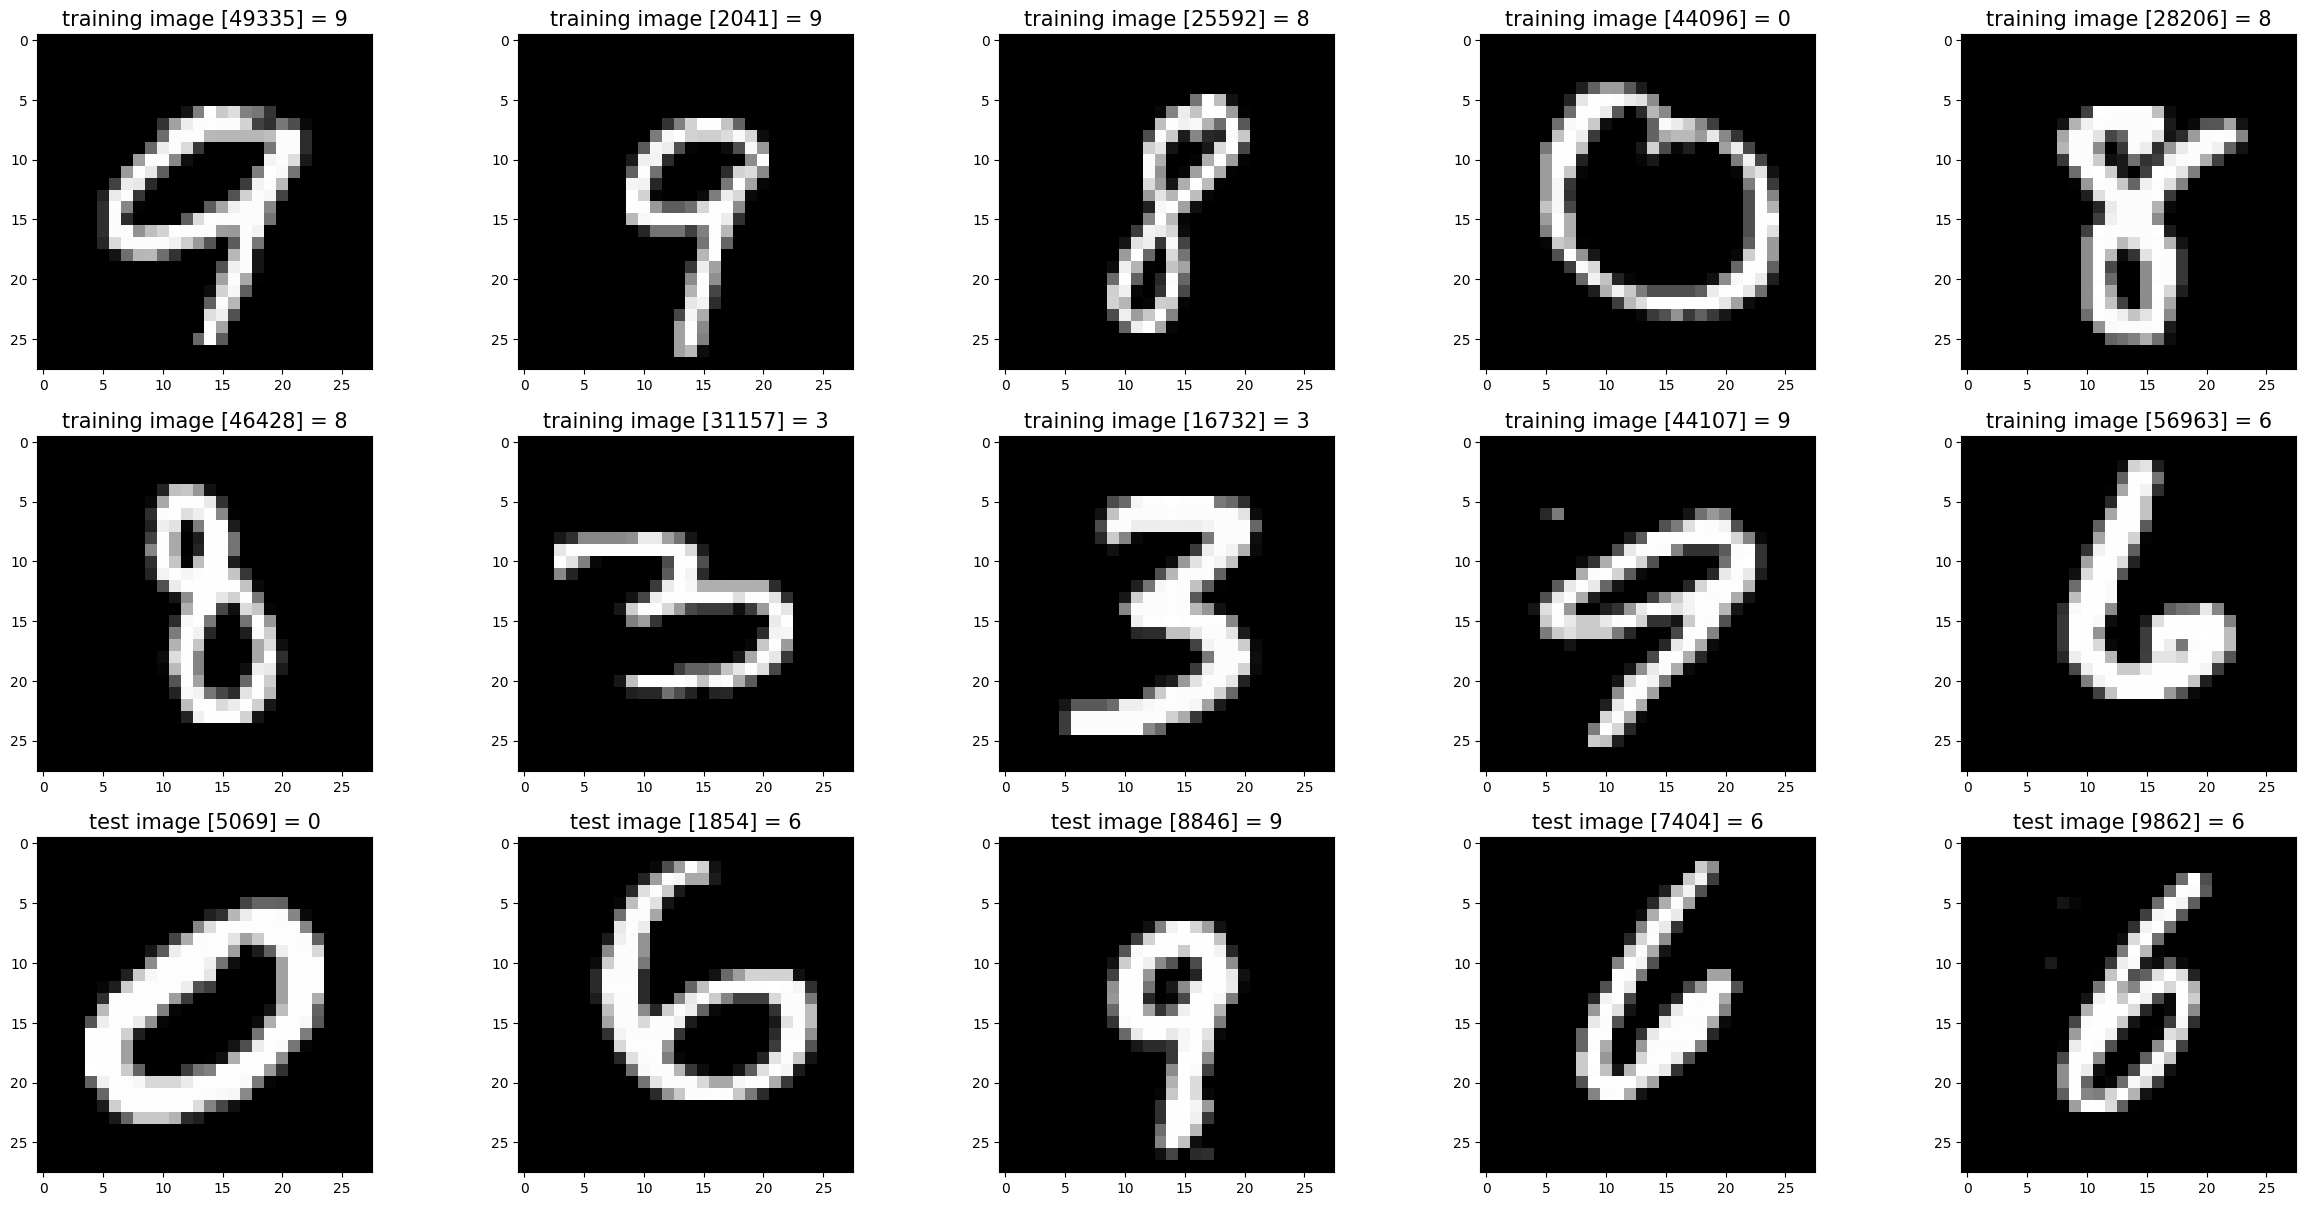

In [25]:
%matplotlib inline
import random
import matplotlib.pyplot as plt

#
# Set file paths based on added MNIST Datasets
#
input_path = '/content/sample_data/Mnist'
training_images_filepath = join(input_path, 'train-images.idx3-ubyte')
training_labels_filepath = join(input_path, 'train-labels.idx1-ubyte')
test_images_filepath = join(input_path, 't10k-images.idx3-ubyte')
test_labels_filepath = join(input_path, 't10k-labels.idx1-ubyte')

#
# Helper function to show a list of images with their relating titles
#
def show_images(images, title_texts):
    cols = 5
    rows = int(len(images)/cols) + 1
    plt.figure(figsize=(30,20))
    index = 1
    for x in zip(images, title_texts):
        image = x[0]
        title_text = x[1]
        plt.subplot(rows, cols, index)
        plt.imshow(image, cmap=plt.cm.gray)
        if (title_text != ''):
            plt.title(title_text, fontsize = 15);
        index += 1

#
# Load MINST dataset
#
mnist_dataloader = MnistDataloader(training_images_filepath, training_labels_filepath, test_images_filepath, test_labels_filepath)
(x_train, y_train), (x_test, y_test) = mnist_dataloader.load_data()

#
# Show some random training and test images
#

images_2_show = []
titles_2_show = []
for i in range(0, 10):
    r = random.randint(1, 60000)
    images_2_show.append(x_train[r])
    titles_2_show.append('training image [' + str(r) + '] = ' + str(y_train[r]))

for i in range(0, 5):
    r = random.randint(1, 10000)
    images_2_show.append(x_test[r])
    titles_2_show.append('test image [' + str(r) + '] = ' + str(y_test[r]))

show_images(images_2_show, titles_2_show)

In [28]:
#Normalizing data to make it compatible with Keras

x_train = np.stack(x_train)
y_train = np.stack(y_train)
x_test = np.stack(x_test)
y_test = np.stack(y_test)

*Model Definition and Training*

In [34]:
import numpy as np
from keras.models import Sequential
from keras.layers import LSTM, Dense
from keras.utils import to_categorical

# Assuming x_train, y_train, x_test, and y_test are your data arrays

num_classes = len(np.unique(y_train))
y_train_one_hot = to_categorical(y_train, num_classes=num_classes)
y_test_one_hot = to_categorical(y_test, num_classes=num_classes)

# Defining the model and it's layers
model = Sequential()

# LSTM layer with 100 units
model.add(LSTM(100, input_shape=(x_train.shape[1], x_train.shape[2])))

# Dense layer for multiclass classification
model.add(Dense(num_classes, activation='sigmoid'))

# Compile the model with adam optimizer and accuracy as the metric
model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])

# Print the model summary
model.summary()

# Train the model
model.fit(x_train, y_train_one_hot, epochs=10, batch_size=32, validation_data=(x_test, y_test_one_hot))

# Evaluate the model on the test set and print metrics
loss, accuracy = model.evaluate(x_test, y_test_one_hot)
print(f'Test Loss: {loss}, Test Accuracy: {accuracy}')

Model: "sequential_12"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm_11 (LSTM)              (None, 100)               51600     
                                                                 
 dense_11 (Dense)            (None, 10)                1010      
                                                                 
Total params: 52610 (205.51 KB)
Trainable params: 52610 (205.51 KB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________
Epoch 1/10
1875/1875 [==============================] - 44s 22ms/step - loss: 0.5747 - accuracy: 0.8065 - val_loss: 0.3794 - val_accuracy: 0.8754
Epoch 2/10
1875/1875 [==============================] - 43s 23ms/step - loss: 0.3325 - accuracy: 0.8889 - val_loss: 0.3051 - val_accuracy: 0.8971
Epoch 3/10
1875/1875 [==============================] - 43s 23ms/step - loss: 0.2748 - accuracy: 0.9079 - val_loss: 0.2

*Model Analysis using SciKitLearn*

313/313 [==============================] - 6s 18ms/step
Confusion Matrix:
[[ 950    0    4    2    0    2    2    0   20    0]
 [   0 1121    6    0    1    2    1    2    2    0]
 [   3    5  983   11    4    2    7    5   11    1]
 [   1    1   18  955    0   22    2    5    5    1]
 [   0    3    6    0  894    3    2   33    4   37]
 [   3    1    6   81    0  772    6    8   12    3]
 [   9    3   11    1    2    6  917    0    8    1]
 [   0   21    7    3   18    2    0  950    4   23]
 [  27    1    9    5    1    8    8    2  907    6]
 [   1    4    3   23   60    4    0  102   10  802]]


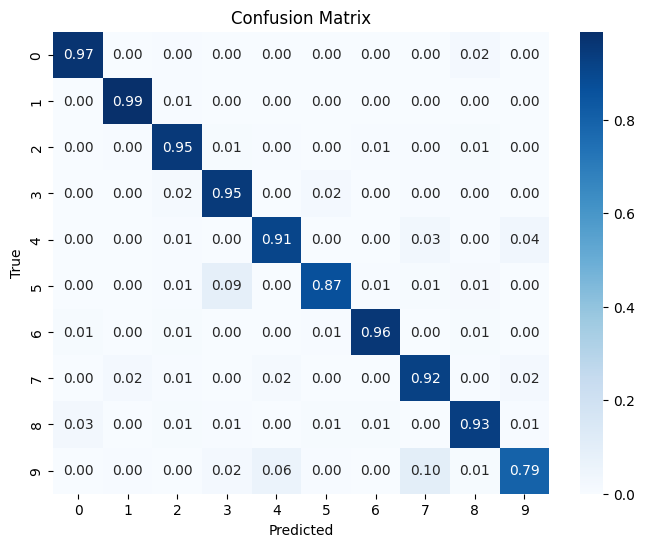

Classification Report:
              precision    recall  f1-score   support

     Class 0       0.96      0.97      0.96       980
     Class 1       0.97      0.99      0.98      1135
     Class 2       0.93      0.95      0.94      1032
     Class 3       0.88      0.95      0.91      1010
     Class 4       0.91      0.91      0.91       982
     Class 5       0.94      0.87      0.90       892
     Class 6       0.97      0.96      0.96       958
     Class 7       0.86      0.92      0.89      1028
     Class 8       0.92      0.93      0.93       974
     Class 9       0.92      0.79      0.85      1009

    accuracy                           0.93     10000
   macro avg       0.93      0.92      0.92     10000
weighted avg       0.93      0.93      0.92     10000



In [40]:
from sklearn.metrics import confusion_matrix, classification_report
import matplotlib.pyplot as plt
import seaborn as sns

# Evaluate the model on the test set
y_pred_one_hot = model.predict(x_test)
y_pred = np.argmax(y_pred_one_hot, axis=1)

# Convert one-hot encoded test labels back to integers
y_true = np.argmax(y_test_one_hot, axis=1)

# Calculate and print confusion matrix
cm = confusion_matrix(y_true, y_pred)
cm_normalized = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
print("Confusion Matrix:")
print(cm)

# Plot the confusion matrix
plt.figure(figsize=(8, 6))
sns.heatmap(cm_normalized, annot=True, fmt=".2f", cmap="Blues", xticklabels=np.unique(y_true), yticklabels=np.unique(y_true))
plt.xlabel("Predicted")
plt.ylabel("True")
plt.title("Confusion Matrix")
plt.show()

# Print classification report
print("Classification Report:")
print(classification_report(y_true, y_pred, target_names=[f"Class {i}" for i in range(num_classes)]))